In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

image_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/")
mask_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/masks/")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [3]:
check = [i for i in mask if "mask" in i]

In [4]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)
        
        print(np.shape(im_array),np.shape(mask_array))
        return im_array,mask_array

In [5]:
dim = 112
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 566/566 [01:53<00:00,  4.98it/s]


(566, 112, 112) (566, 112, 112)


100%|██████████| 138/138 [01:04<00:00,  2.13it/s]


In [6]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [7]:
print(np.shape(images))

(704, 112, 112, 1)


In [8]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(112,112,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [9]:
model = unet(input_size=(112,112,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
#model.summary()

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [11]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.01, 
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 30,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)



/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: -0.3757 - dice_coef: 0.3763 - binary_accuracy: 0.4756
Epoch 1: val_loss improved from inf to -0.47790, saving model to cxr_reg_weights.best.hdf5
40/40 [==============================] - 21s 114ms/step - loss: -0.3757 - dice_coef: 0.3763 - binary_accuracy: 0.4756 - val_loss: -0.4779 - val_dice_coef: 0.4779 - val_binary_accuracy: 0.4665 - lr: 2.0000e-04
Epoch 2/30
39/40 [============================>.] - ETA: 0s - loss: -0.6518 - dice_coef: 0.6518 - binary_accuracy: 0.7695
Epoch 2: val_loss improved from -0.47790 to -0.81676, saving model to cxr_reg_weights.best.hdf5
40/40 [==============================] - 2s 60ms/step - loss: -0.6518 - dice_coef: 0.6524 - binary_accuracy: 0.7699 - val_loss: -0.8168 - val_dice_coef: 0.8168 - val_binary_accuracy: 0.9172 - lr: 2.0000e-04
Epoch 3/30
39/40 [============================>.] - ETA: 0s - loss: -0.8523 - dice_coef: 0.8523 - binary_accuracy: 0.9268
Epoch 3: val_loss improved from

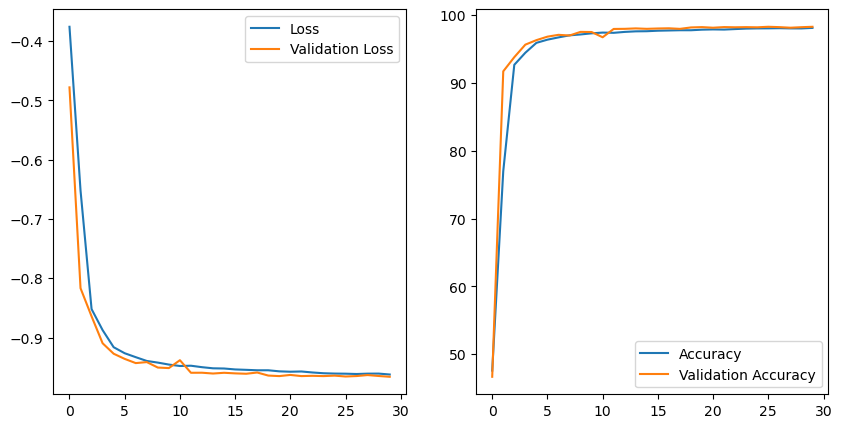

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [13]:
normalPath = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'

abnormalPath = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images'


In [14]:
test = []

testData = []
x= 0
for f in tqdm(os.listdir(normalPath)):
    if(x < 1250):
        im = cv2.imread('/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/'+f)
        im = cv2.resize(im, (dim, dim))
        im = im[:,:,0]
        im = im.reshape(dim,dim,1)
        test.append(im)
        x = x + 1
    else:
        im = cv2.imread('/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/'+f)
        im = cv2.resize(im, (dim, dim))
        im = im[:,:,0]
        im = im.reshape(dim,dim,1)
        testData.append(im)
        x = x + 1
print(np.array(test).shape)

100%|██████████| 10192/10192 [02:22<00:00, 71.35it/s]

(1250, 112, 112, 1)


In [15]:
test2 = []
testDataAbnormal = []
x= 0
for f in tqdm(os.listdir(abnormalPath)):
    if(x < 1250):
        im = cv2.imread('/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/'+f)
        im = cv2.resize(im, (dim, dim))
        im = im[:,:,0]
        im = im.reshape(dim,dim,1)
        test2.append(im)
        x = x + 1
    else:
        im = cv2.imread('/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/'+f)
        im = cv2.resize(im, (dim, dim))
        im = im[:,:,0]
        im = im.reshape(dim,dim,1)
        testDataAbnormal.append(im)
        
print(np.array(test2).shape)

100%|██████████| 1345/1345 [00:17<00:00, 74.78it/s]

(1250, 112, 112, 1)


In [16]:
import gc
gc.collect()

1781

In [17]:
def mode_prediction(start,end,arr):
    tval = []
    for tpost in tqdm(range(start,end)):
        nval = test[tpost]
        val = (nval-127.0)/127.0
        tval.append(val)
    return tval

In [18]:
final_preds = model.predict(np.array(test))

40/40 [==============================] - 3s 31ms/step


In [19]:
final_preds2 = model.predict(np.array(test2))

40/40 [==============================] - 1s 32ms/step


In [20]:
final_preds3 = model.predict(np.array(testData))

280/280 [==============================] - 10s 36ms/step


In [21]:
final_preds4 = model.predict(np.array(testDataAbnormal))

3/3 [==============================] - 1s 725ms/step


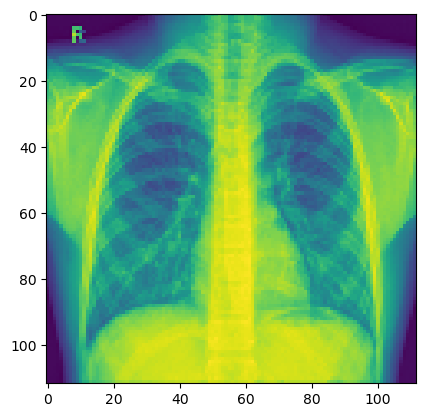

In [22]:
from PIL import Image
plt.imshow((np.squeeze(test[0], axis=2)))

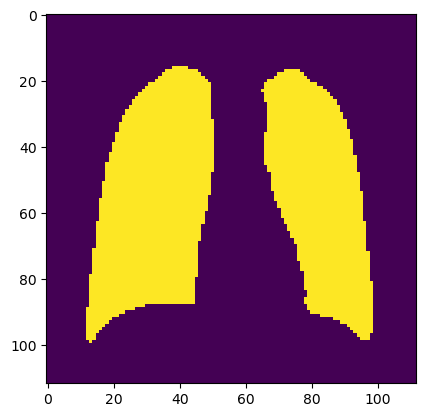

In [23]:
plt.imshow((np.squeeze(final_preds[0], axis=2)))

In [24]:

import cv2
import numpy as np


def cleanUp(image):
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(image, kernel, iterations=1)
    dilated_image = cv2.dilate(eroded_image, kernel, iterations=1)
    return dilated_image


def convex(mask):
    red_channel = mask[:, :, 0]

    _, binary_mask = cv2.threshold(red_channel, thresh=0.1, maxval=255, type=cv2.THRESH_BINARY)
    binary_mask = binary_mask.astype(np.uint8)

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    height, width = binary_mask.shape[:2]
    closed_mask = np.zeros((height, width), dtype=np.uint8)

    if len(contours) > 0:
        hull = cv2.convexHull(np.concatenate(contours))

        cv2.drawContours(closed_mask, [hull], -1, 255, thickness=cv2.FILLED)
    return(closed_mask)

def cut(original_image,original_mask):
    original_mask_binary = (original_mask > 0.5).astype(np.uint8)
    masked_image = original_image * original_mask_binary
    return(masked_image)

def zoom(original_mask, original_image):
    original_mask_binary = (original_mask > 0.5).astype(np.uint8)

    nonzero_indices = np.argwhere(original_mask_binary[:, :, 0])

    if len(nonzero_indices) == 0:
        return original_image

    (y_min, x_min), (y_max, x_max) = nonzero_indices.min(0), nonzero_indices.max(0) + 1

    zoomed_image = original_image[y_min - 7:y_max+ 7, x_min - 7:x_max + 7, :]
    return zoomed_image

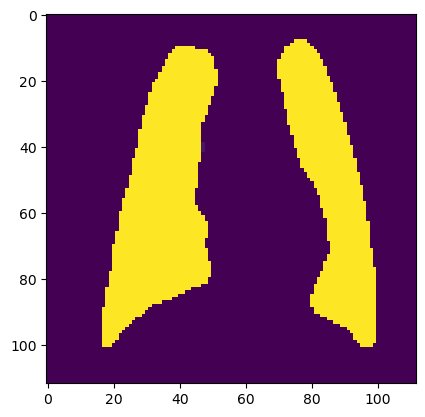

In [25]:
def process(orginal_images,original_masks):
    test = orginal_images
    final_preds = original_masks
    cleanPreds = []
    for image in final_preds:
        cleanPreds.append(cleanUp(image))

    #num_images = 3
    height, width = dim, dim

    array_of_images_with_channel = np.expand_dims(cleanPreds, axis=-1)

    convexedMasks = []
    for image in array_of_images_with_channel:
        convexedMasks.append(np.expand_dims(convex(image), axis=-1))

    plt.imshow((np.squeeze(array_of_images_with_channel[1], axis=2)))
    
    cutImages = []
    for i in range(len(test)):
        cutImages.append(cut(test[i],convexedMasks[i]))

#     zoomed_abnormal = []
#     for i in range(len(final_preds)):
#         zoomed_abnormal.append(zoom(convexedMasks[i], cutImages[i]))
#     print(len(zoomed_abnormal))
    return(cutImages)

abnormal_all = process(test2,final_preds2)
normal_all = process(test,final_preds)


predictNormal = process(testData, final_preds3)

predictAbnormal =  process(testDataAbnormal, final_preds4)





# # Calculate the lengths of the two arrays
# twenty_percent_length = len(abnormal_all) * 0.5
# eighty_percent_length = len(abnormal_all) * 0.5

# # Convert the lengths to integers (rounding down)
# twenty_percent_length = int(twenty_percent_length)
# eighty_percent_length = int(eighty_percent_length)

# abnormal_test = abnormal_all[:twenty_percent_length]
# abnormal_train = abnormal_all[twenty_percent_length:]
# normal_test = normal_all[:twenty_percent_length]
# normal_train = normal_all[twenty_percent_length:]

# print(len(abnormal_train))
# print(len(normal_train))

# print(len(normal_test))
# print(len(abnormal_test))

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Assuming you have two arrays of images, array1 and array2
# with shapes (num_images1, 112, 112, 1) and (num_images2, 112, 112, 1) respectively.
array1 = normal_all
array2 = abnormal_all


# Combine the two arrays and create labels (0 for array1, 1 for array2)
array1_labels = np.zeros(len(array1))
array2_labels = np.ones(len(array2))
images = np.concatenate([array1, array2], axis=0)
labels = np.concatenate([array1_labels, array2_labels], axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Build the model
modelClassifer = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(112, 112, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
modelClassifer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
binary_history = modelClassifer.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = modelClassifer.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

# Make predictions
predictions = modelClassifer.predict(X_test)

# Round the predictions to the nearest integer (0 or 1)
rounded_predictions = np.round(predictions)

# Now you can compare the rounded predictions with the actual labels (y_test) to see how well the model performed.
# For example, to check the first 10 predictions:
for i in range(10):
    print(f"Predicted: {rounded_predictions[i]}, Actual: {y_test[i]}")

Epoch 1/50
57/57 [==============================] - 5s 21ms/step - loss: 3.5081 - accuracy: 0.7083 - val_loss: 0.3697 - val_accuracy: 0.8450
Epoch 2/50
57/57 [==============================] - 1s 13ms/step - loss: 0.2945 - accuracy: 0.8756 - val_loss: 0.2198 - val_accuracy: 0.9100
Epoch 3/50
57/57 [==============================] - 1s 13ms/step - loss: 0.2130 - accuracy: 0.9156 - val_loss: 0.2709 - val_accuracy: 0.8900
Epoch 4/50
57/57 [==============================] - 1s 13ms/step - loss: 0.1532 - accuracy: 0.9417 - val_loss: 0.1887 - val_accuracy: 0.9200
Epoch 5/50
57/57 [==============================] - 1s 13ms/step - loss: 0.1277 - accuracy: 0.9533 - val_loss: 0.1541 - val_accuracy: 0.9450
Epoch 6/50
57/57 [==============================] - 1s 13ms/step - loss: 0.1069 - accuracy: 0.9556 - val_loss: 0.2098 - val_accuracy: 0.9200
Epoch 7/50
57/57 [==============================] - 1s 14ms/step - loss: 0.0810 - accuracy: 0.9667 - val_loss: 0.1387 - val_accuracy: 0.9400
Epoch 8/50
57

In [27]:
pip install keras-vis


Note: you may need to restart the kernel to use updated packages.


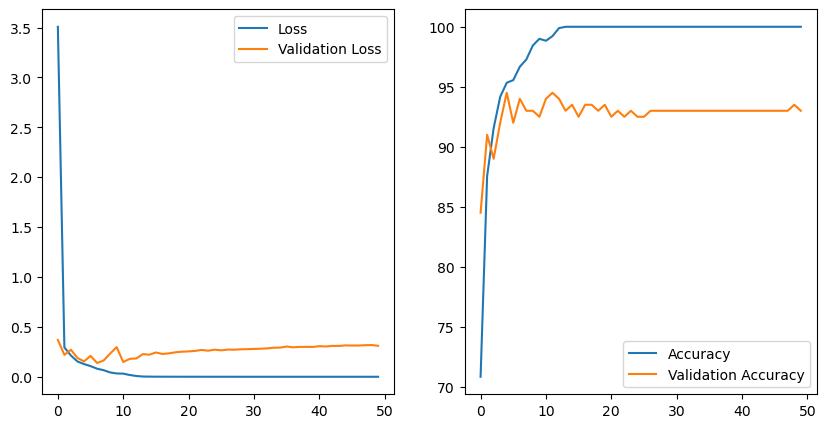

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(binary_history.history['loss'], '-', label = 'Loss')
ax1.plot(binary_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(binary_history.history['accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(binary_history.history['val_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

16/16 [==============================] - 0s 4ms/step


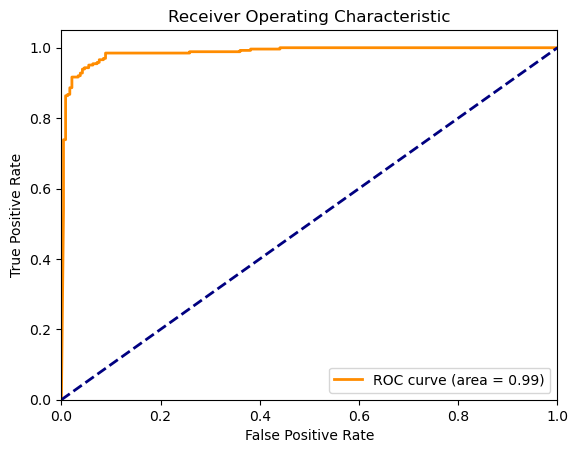

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

# Load your trained TensorFlow Sequential model


# Load and preprocess your validation/test data
X_val = X_test
y_true = y_test

# Generate predictions from the model
y_pred = modelClassifer.predict(X_val)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [35]:
loss, accuracy = modelClassifer.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

# Make predictions
predictions = modelClassifer.predict(X_test)

# Round the predictions to the nearest integer (0 or 1)
rounded_predictions = np.round(predictions)

# Now you can compare the rounded predictions with the actual labels (y_test) to see how well the model performed.
# For example, to check the first 10 predictions:
FP = 0
TN = 0
for i in range((len(X_test) - 2)):
    if(rounded_predictions[i] == y_test[i]):
        print(True)
    elif (rounded_predictions[i] > y_test[i]):
        print(False)
        FP = FP + 1
    else:
        print(False)
        TN = TN + 1
        

print("Total Amount of predictions: ", len(X_test))
print("Accuracy: ", len(X_test) / (FP + TN + len(X_test)))
    
    #print(f"Predicted: {rounded_predictions[i]}, Actual: {y_test[i]}")

16/16 [==============================] - 0s 5ms/step - loss: 0.2989 - accuracy: 0.9420
Test accuracy: 0.9419999718666077
16/16 [==============================] - 0s 4ms/step
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tr

In [36]:
predictions = modelClassifer.predict(np.asarray(predictNormal))

# Round the predictions to the nearest integer (0 or 1)
rounded_predictions = np.round(predictions)
num = 0
for pred in rounded_predictions:
    if(pred != 0 ):
        num = num+1
        
predictions2 = modelClassifer.predict(np.asarray(predictAbnormal))

# Round the predictions to the nearest integer (0 or 1)
rounded_predictions2 = np.round(predictions2)
num2 = 0
for pred in rounded_predictions2:
    if(pred != 1 ):
        num2 = num2+1
        
print("acc on normal data: ", len(predictNormal) / (len(predictNormal) + num))
print("acc on abnormal data: ", len(predictAbnormal) / (len(predictAbnormal) + num2))

3/3 [==============================] - 0s 4ms/step
acc on normal data:  0.9341830338487255
acc on abnormal data:  0.9693877551020408


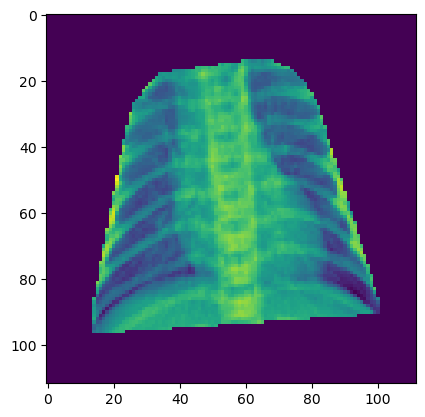

In [37]:
 plt.imshow((np.squeeze(predictNormal[x], axis=2)))

In [38]:
for x in range(10):
   
    print("0 = normal, 1 = pneumonia")
    print(print(f"Predicted: {rounded_predictions[x]}, Actual: {y_test[x]}"))


0 = normal, 1 = pneumonia
Predicted: [0.], Actual: 1.0
None
0 = normal, 1 = pneumonia
Predicted: [1.], Actual: 0.0
None
0 = normal, 1 = pneumonia
Predicted: [0.], Actual: 0.0
None
0 = normal, 1 = pneumonia
Predicted: [0.], Actual: 1.0
None
0 = normal, 1 = pneumonia
Predicted: [0.], Actual: 1.0
None
0 = normal, 1 = pneumonia
Predicted: [0.], Actual: 0.0
None
0 = normal, 1 = pneumonia
Predicted: [0.], Actual: 1.0
None
0 = normal, 1 = pneumonia
Predicted: [0.], Actual: 1.0
None
0 = normal, 1 = pneumonia
Predicted: [0.], Actual: 0.0
None
0 = normal, 1 = pneumonia
Predicted: [0.], Actual: 1.0
None
